In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from smol.plotting import  register_seaborn_palettes
import torch
import pandas as pd

sns.set_style("white")
register_seaborn_palettes()

In [16]:
%%time

%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("white")
# matplotlib.use('nbAgg')

project_name = "smol_one_fp32_neuron"
group_name = "v15_sweep_w_decay"
# print(os.environ.get("DISPLAY"))
# os.environ["DISPLAY"] = "localhost:0.0"
print(f"{plt.get_backend()=}")

import wandb
api = wandb.Api()
runs = api.runs(f"haroun7/{project_name}", filters={"group": group_name, "config.bias": True})

print(f"Loading {len(runs)} runs from {group_name=}")

dfs = []
for run in runs:
    df = run.history()
    dfs.append({
        "df": df,
        **run.config,
    })

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
plt.get_backend()='module://matplotlib_inline.backend_inline'
Loading 326 runs from group_name='v15_sweep_w_decay'
CPU times: user 3.81 s, sys: 10.8 ms, total: 3.82 s
Wall time: 2min 55s


In [51]:
import matplotlib.pyplot as plt
import plotly.express as px


def make_trajectory_plot(df_idx: int, ax: plt.Axes, title_n: bool = False, fontsize: int = 12) -> None:
    # plt.figure(figsize=(4, 4))
    _df = dfs[df_idx]["df"][["step", "weight", "bias"]].dropna().sort_values("step")

    ax.plot(_df['weight'], _df['bias'], marker='o', linestyle='-', label="convergence")

    ax.plot(_df['weight'], -_df['weight'] * dfs[df_idx]["threshold"], label="correct")
    # plt.plot(_df['weight'], -_df['weight'] * dfs[df_idx]["threshold_upper"], label="upper")
    # plt.plot(_df['weight'], -_df['weight'] * dfs[df_idx]["threshold_lower"], label="lower")

    # Annotate the starting step
    start_step = int(_df['step'].iloc[0])
    start_x = _df['weight'].iloc[0]
    start_y = _df['bias'].iloc[0]

    ax.annotate(text=f"Step {start_step}", xy=(start_x, start_y - 0.008), xycoords="data")#, xytext=(-10, -10), textcoords="offset pixels", fontsize=35)

    ax.set_xlabel('Weight')
    ax.set_ylabel('Bias')
    n = dfs[df_idx]["n"]
    bs = dfs[df_idx]["batch_size"]
    lr = dfs[df_idx]["lr"]
    weight_decay = dfs[df_idx]["weight_decay"]

    title = ""
    if title_n:
        title += f"{n=} "
    ax.set_title(title + f"{bs=} {lr=} wd={weight_decay:.0e}", fontsize=fontsize)


In [5]:
dfs_index = []
for idx, lol in enumerate(dfs):
    dfs_index.append((
        idx,
        lol["n"],
        lol["batch_size"],
        lol["lr"],
        lol["weight_decay"],
        lol["bias"],
        lol["threshold_type"],
    ))
dfs_index = pd.DataFrame.from_records(dfs_index, columns=["idx", "n", "batch_size", "lr", "weight_decay", "bias", "threshold_type"])
dfs_index.head(3)

idx      n  batch_size   lr  weight_decay  bias threshold_type
0    0  16384         1.0  2.0           2.0  True     randn_0.25
1    1  16384         1.0  2.0           1.0  True     randn_0.25
2    2  16384         1.0  2.0           0.5  True     randn_0.25

In [48]:
dfs_index[
    (dfs_index.lr == 2.) & (dfs_index.n == 16384) & (dfs_index.weight_decay == 0.01) & (dfs_index.bias == True) & (dfs_index.threshold_type == "randn_0.25")
]

idx      n  batch_size   lr  weight_decay  bias threshold_type
24   24  16384        0.01  2.0          0.01  True     randn_0.25

[155, 127, 106, 99, 92, 71, 24]
[154, 126, 105, 98, 91, 70, 23]
[153, 125, 104, 97, 90, 69, 22]
[152, 124, 103, 96, 89, 68, 21]
[151, 123, 102, 95, 88, 67, 20]
[150, 122, 101, 94, 87, 66, 19]
[149, 121, 100, 93, 86, 65, 18]


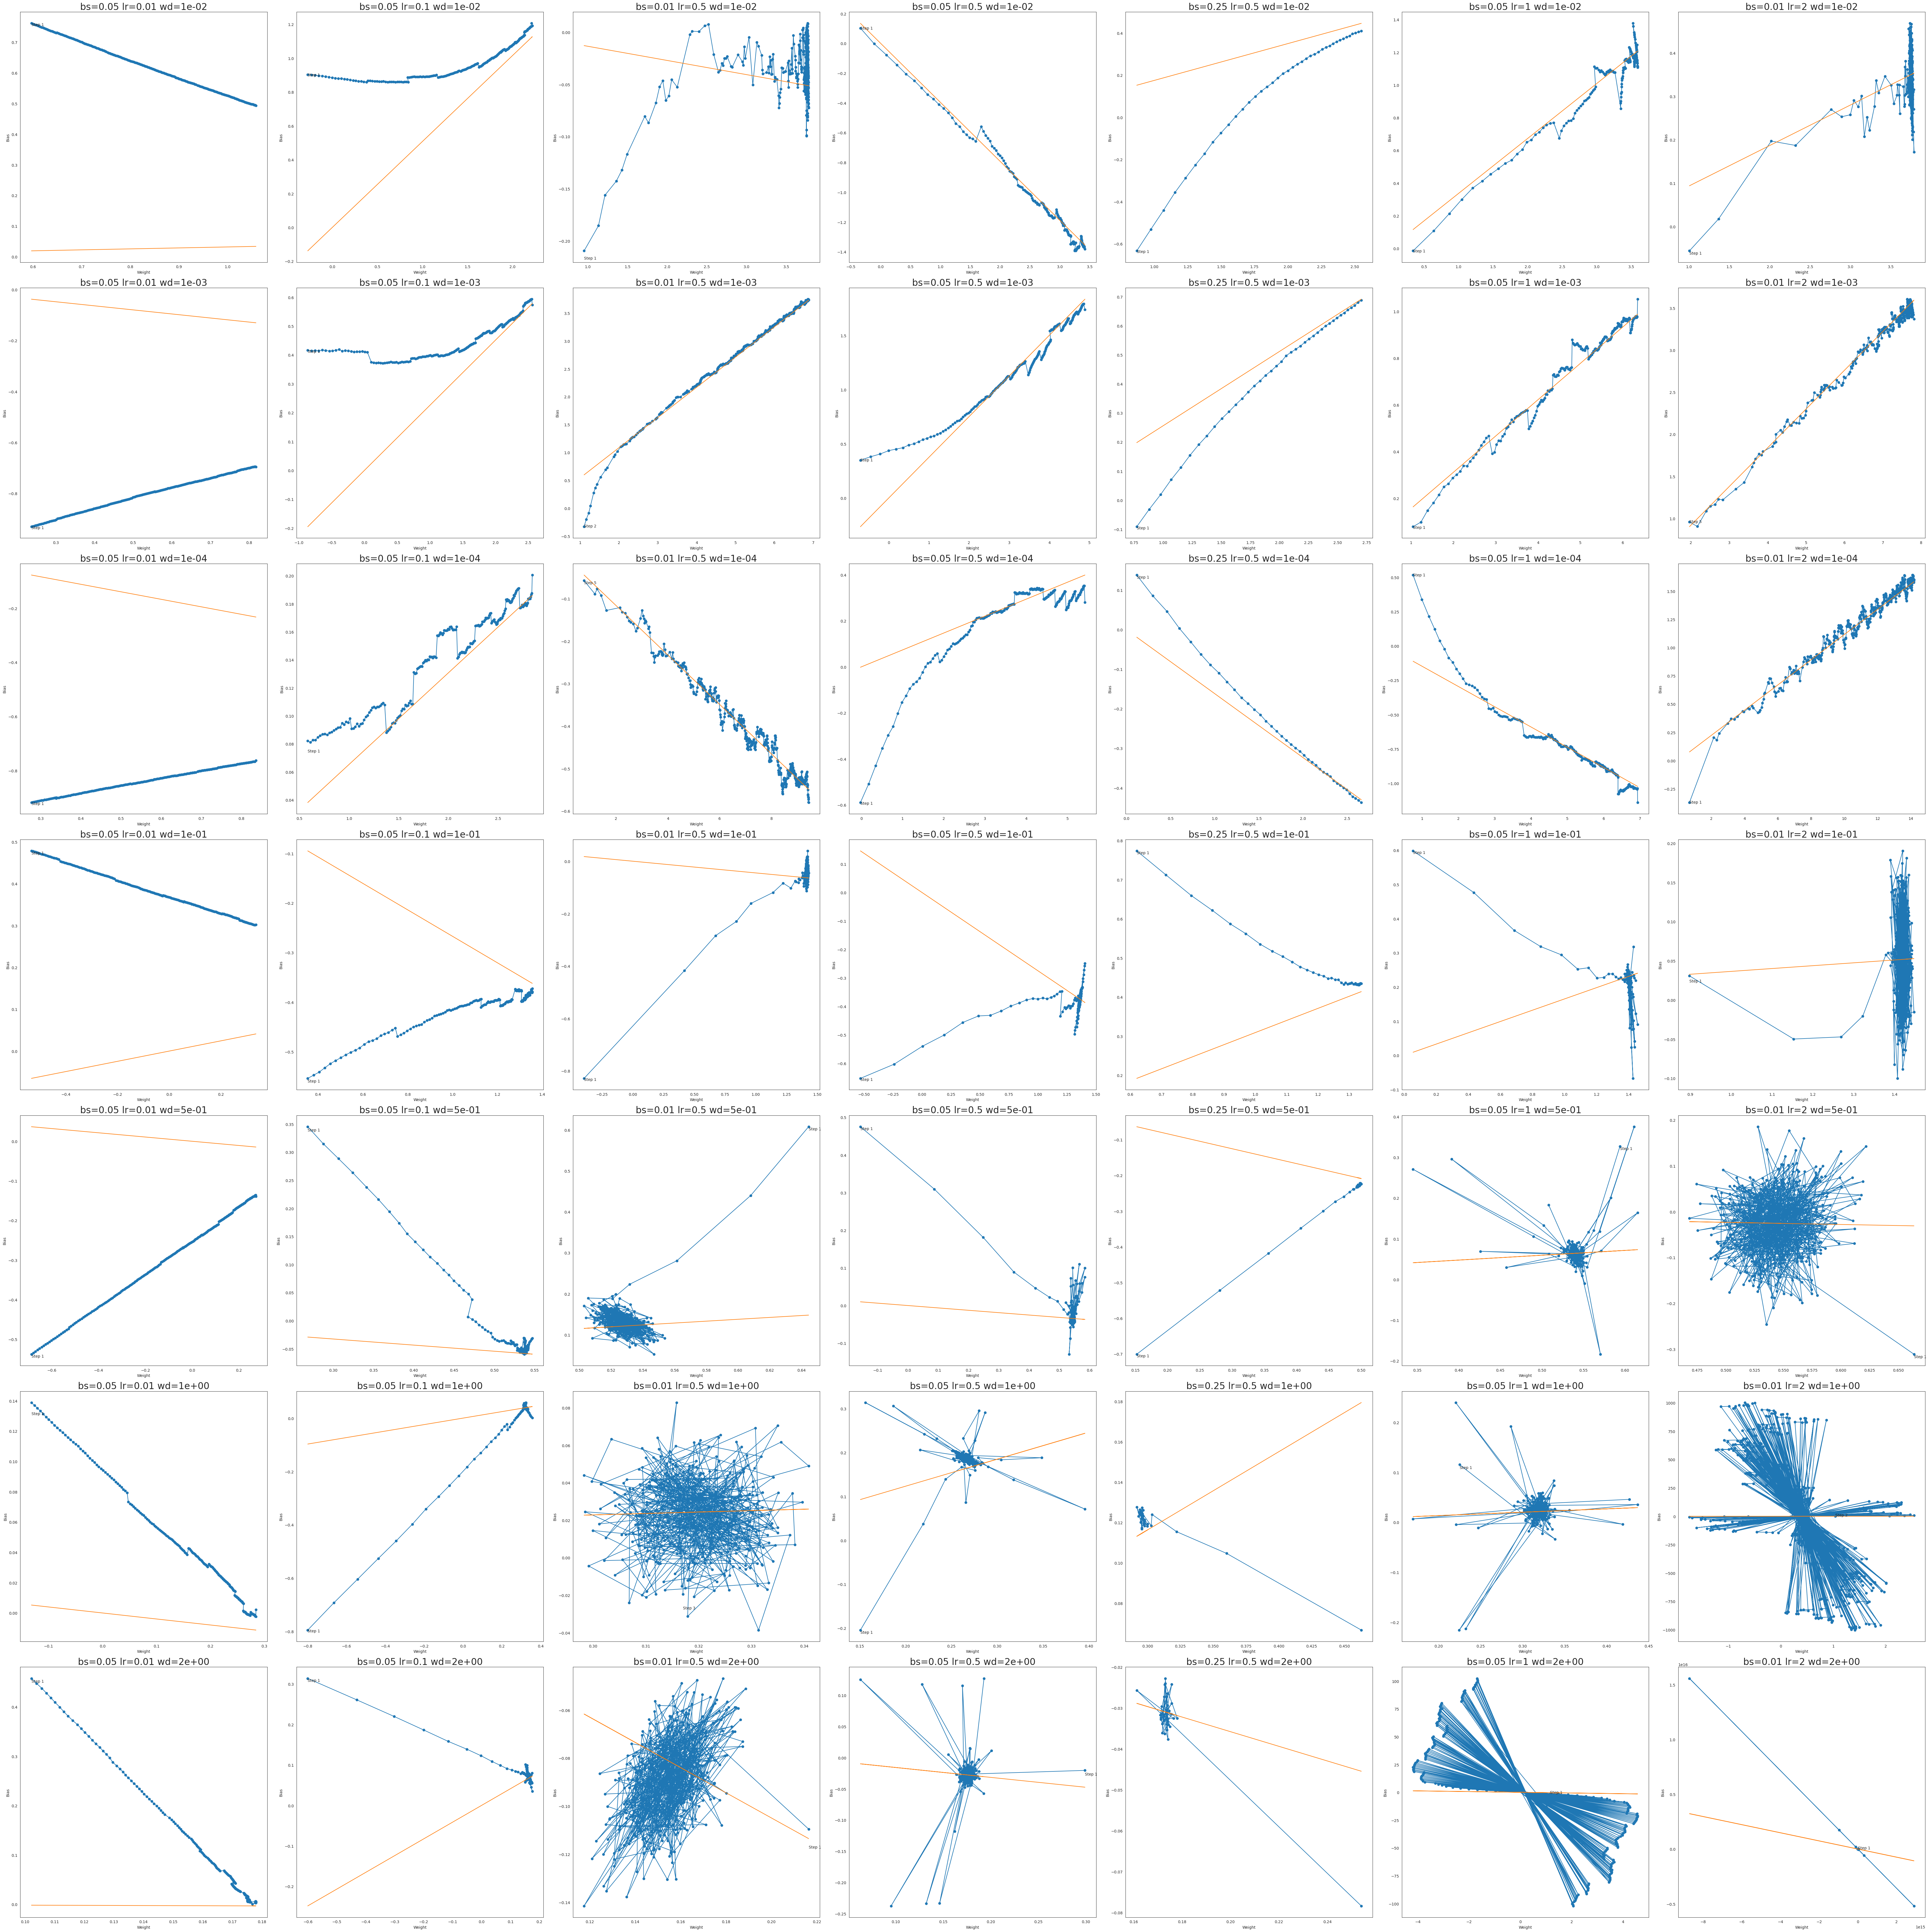

In [54]:
wds = [1e-2, 1e-3, 1e-4, 0.1, 0.5, 1.0, 2.0]
bl = [
    (0.05, 0.01), (0.05, 0.1),  # lower LR
    (0.01, 0.5), (0.05, 0.5), (0.25, 0.5),  # increase batch size
    (0.05, 1.0), (0.01, 2.0),  # higher LR
]
ns = [16384]

for n in ns:
    fig, axes = plt.subplots(nrows=len(wds), ncols=len(bl), figsize=(10 * len(wds), 10 * len(bl)))

    for row, wd in enumerate(wds):
        all_idxs = []
        for col, (b, l) in enumerate(bl):
            ax = axes[row, col]
            idxs = dfs_index[
                (dfs_index.weight_decay == wd) & (dfs_index.lr == l) & (dfs_index.n == n) & (dfs_index.batch_size == b) & (dfs_index.bias == True) & (dfs_index.threshold_type == "randn_0.25")
            ].idx.to_list()
            if len(idxs) > 0:
                idx = idxs[0]
            else:
                print(f"couldnt find example for setting {n=} {wd=} {b=} {l=}")
                continue
            all_idxs.append(idx)
            make_trajectory_plot(idx, ax, fontsize=24)
        print(all_idxs)
    fig.tight_layout()
    plt.savefig(f"outputs/one_perceptron_pt2/full_graph_n{n}.png", bbox_inches="tight")
    plt.show()


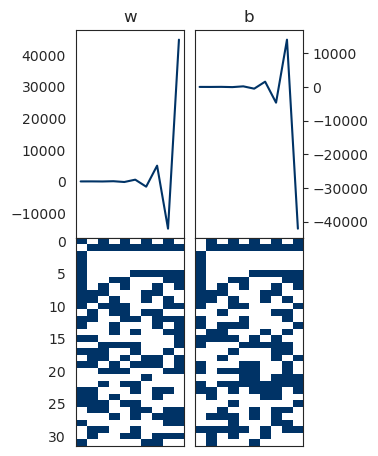

In [38]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def float_to_bits(float_num):
    # Example usage
    # float_num = 3.14
    # bits_string = float_to_bits(float_num)
    # print(bits_string)

    # Pack the floating-point number into its binary representation
    binary_representation = struct.pack('!f', float_num)

    # Convert the bytes to a binary string
    binary_string = ''.join(f'{byte:08b}' for byte in binary_representation)

    return binary_string

# Apply the float_to_bits function element-wise
vectorized_float_to_bits = np.vectorize(float_to_bits)

def make_bool(array: np.ndarray) -> None:
    # Create a boolean array of shape (10, 32)
    boolean_array = np.zeros((array.shape[0], 32), dtype=bool)

    # Iterate over each character in the binary strings and set the corresponding boolean array values
    for i, binary_string in enumerate(array):
        boolean_array[i] = np.array([x == '1' for x in list(binary_string)], dtype=bool)
    return boolean_array


# parameter = [w b] but as bits
def bitplot(idx: int) -> None:
    _df = dfs[idx]["df"]
    _df = _df[_df.step > 0]
    w = _df.weight.to_numpy().astype(np.float32)
    b = _df.bias.to_numpy().astype(np.float32)
    step = _df.step

    bits_array = vectorized_float_to_bits(w)
    # print(type(bits_array))
    # print(boolean_array)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3, 5))
    fig.tight_layout(rect=[0, 0.0, 1, 0.95])

    color = "#003366"
    cmap = ListedColormap(['w', color])
    axes[0, 0].plot(list(range(len(w))), w, color=color)
    axes[1, 0].matshow(make_bool(vectorized_float_to_bits(w)).T, aspect="auto", cmap=cmap)
    # print(b)
    axes[0, 1].plot(list(range(len(b))), b, color=color)
    axes[1, 1].matshow(make_bool(vectorized_float_to_bits(b)).T, aspect="auto", cmap=cmap)

    axes[0, 1].yaxis.tick_right()
    axes[1, 1].set_yticks([])
    [ax.set_xticks([]) for ax in axes.flatten()]

    fig.subplots_adjust(hspace=0.0, wspace=0.1)

    # fig.suptitle(f"{idx=}", ha="left")
    axes[0, 0].set_title("w")
    axes[0, 1].set_title("b")
    # plt.title(f"w, b binary for {idx=}")
    plt.savefig(f"outputs/one_perceptron_pt2/bitplots/wd_idx_{idx}.png", bbox_inches="tight")
    plt.show()
bitplot(0)

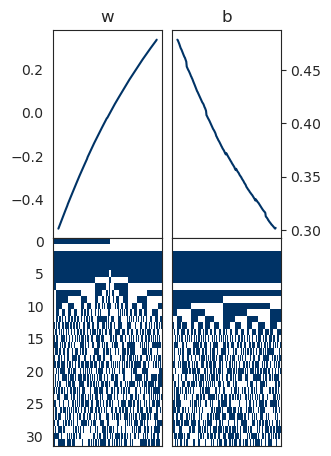

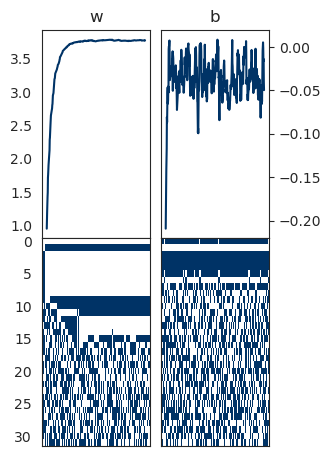

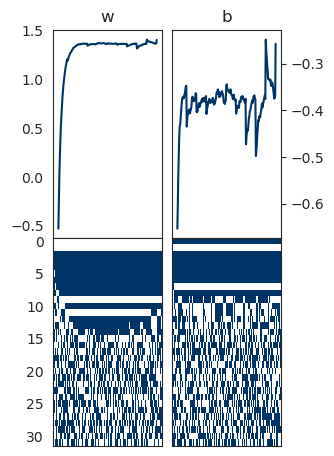

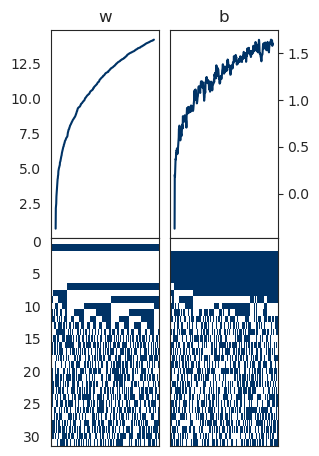

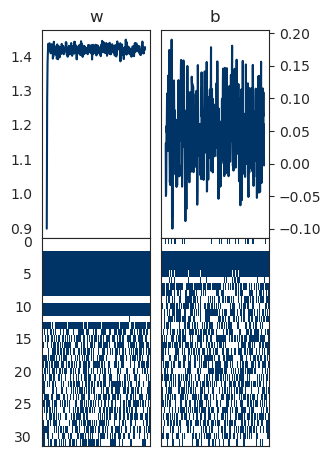

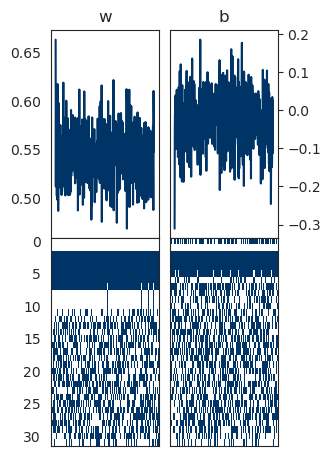

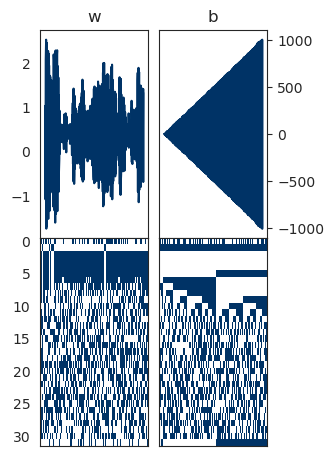

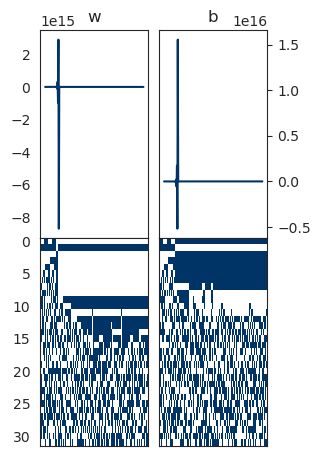

In [55]:
for idx in [152, 106, 96, 22, 21, 20, 19, 18]:
    bitplot(idx)

In [58]:
dirname = "outputs/one_perceptron_pt2/bitplots"
from PIL import Image

image_indices = [152, 106, 96, 22, 21, 20, 19, 18]
images = [Image.open(f"{dirname}/wd_idx_{i}.png") for i in image_indices]

image_indices = [78, 86, 87, 105]
images.extend([Image.open(f"{dirname}/idx_{i}.png") for i in image_indices])

# Create a new blank image with a white background
nrows = 3
ncols = 4
output_width = nrows * images[0].width
output_height = ncols * images[0].height
output_image = Image.new("RGB", (output_width, output_height), "white")

# Paste the four images onto the new image
for row in range(nrows):
    for col in range(ncols):
        output_image.paste(images[row * ncols + col], (row * images[0].width, col * images[0].height))

# Save the final output image
output_image.save(f"{dirname}/output_image_2.png")

# Optionally, you can also display the image
output_image.show()
